#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
# diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[0.005, 0.   , 0.   ],
       [0.   , 0.005, 0.   ],
       [0.   , 0.   , 0.01 ]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[0.005, 0.   , 0.   ],
       [0.   , 0.005, 0.   ],
       [0.   , 0.   , 0.01 ]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [20]:
E = 210e9

In [21]:
E*Ar/1e10

1.6991625880187402

In [22]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [23]:
DT=np.diag(diag_DT) # (35) in [2]

In [24]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [25]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [26]:
CT=np.diag(diag_CT)

In [27]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [28]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [29]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [33]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.98817078,  0.08166245, -0.1298066 ],
       [-0.14747354,  0.73821984, -0.65824237],
       [ 0.04207212,  0.66959891,  0.74153033]])

In [34]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.009424


In [35]:
Ret.shape

(50, 3, 3)

In [36]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [37]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [38]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000908


In [39]:
C1(dx,dy,dz,Ret)

array([[-3.06672820e-02, -2.55259575e-01,  4.29884096e+00,
        -3.14033005e-01,  1.18997188e+00,  9.14346496e-02,
        -5.47175054e+00,  6.01504395e-01,  6.15131845e-01,
         7.46169523e-02,  1.97521590e+00,  2.05546414e-01,
         3.91881335e-01, -1.02453763e-01,  1.92699094e+00,
        -1.06715185e+00,  1.88641001e-01,  2.96010826e-01,
        -2.19909301e-02,  1.23788947e+00,  1.76313606e-01,
        -2.29517911e-02, -3.76717853e+00, -1.75435364e-01,
         3.15385225e+00, -1.28534825e+00,  1.00002746e+00,
        -3.08142179e-03,  1.25539757e-01, -3.44895724e-01,
         6.51925109e-01, -1.82611452e+00,  1.23550001e-01,
         1.14059626e+00, -1.27786027e-01,  1.74353012e-01,
         4.94816312e-02,  3.85484201e-01,  3.92407673e+00,
        -8.67453989e-02, -2.16486047e-01,  1.86982064e-01,
        -9.64556130e-01,  2.67284392e+00,  7.09689698e-03,
        -3.03081177e+00, -2.55751262e-02,  1.65475968e+00,
        -1.27213242e+00, -1.09816088e-01],
       [-3.25

In [40]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [41]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.76000572e+02, -1.87069897e+04,  2.57670403e+03],
       [-1.46494337e+03,  2.08244468e+03,  8.45246846e+03],
       [ 2.46711942e+04, -7.25196978e+01, -1.24238446e+02],
       [-1.80224607e+03,  2.10192340e+03,  2.23994294e+03],
       [ 6.82928900e+03, -7.76120586e+02, -2.76422069e+02],
       [ 5.24746557e+02, -6.99313963e+03, -9.08760148e+03],
       [-3.14025621e+04,  9.41508765e+03, -1.26135519e+04],
       [ 3.45205414e+03,  9.13897906e+03, -2.23488945e+03],
       [ 3.53026253e+03,  1.50411475e+04, -1.00964024e+04],
       [ 4.28229222e+02, -1.25875720e+04,  1.42702003e+03],
       [ 1.13358311e+04,  5.73214046e+02, -3.86531076e+02],
       [ 1.17963784e+03, -8.11785733e+02, -5.38136256e+02],
       [ 2.24902028e+03, -4.92804780e+03, -2.44541786e+02],
       [-5.87985625e+02,  1.25266201e+04, -2.86540845e+03],
       [ 1.10590664e+04, -8.50921072e+03,  1.36016125e+04],
       [-6.12442070e+03, -1.62757119e+04, -4.26182054e+02],
       [ 1.08261711e+03,  2.69308055e+03

In [42]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000643


In [43]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [44]:
I=np.identity(3)

In [45]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000512


In [46]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [47]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [49]:
DR=np.diag(diag_DR) 

In [50]:
Ar

0.08091250419136858

In [51]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [52]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [53]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [54]:
def Re_b(Ret):
    return Ret

In [55]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000132


In [56]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [57]:
phi(x,y,z,Ret,None,None)

array([[ 1.68342795e+00,  1.29389486e+00, -1.27587348e-01],
       [-2.96969724e-01, -1.74438936e-01,  5.46836971e-01],
       [ 1.09661072e+00, -7.79851501e-01, -6.83151146e-01],
       [-2.78181565e-01,  6.20847664e-01, -8.49980545e-01],
       [-1.07521153e+00, -1.54275673e+00,  1.71505213e-01],
       [ 5.15897890e-01,  2.87738965e-01, -8.66707462e-01],
       [-3.50254544e-01, -8.73344648e-01,  9.88307326e-01],
       [-1.33640702e-01,  5.72579570e-02,  7.86966587e-01],
       [ 1.06804988e-03,  1.38080997e+00, -5.97675178e-01],
       [-6.27523905e-01, -2.55171439e-01, -9.41883220e-01],
       [-1.67595971e+00, -1.21508020e+00, -1.36945807e-01],
       [-8.60106118e-01, -4.51199980e-01,  1.46628801e+00],
       [-5.62309640e-01,  7.12029350e-01, -1.24027460e+00],
       [-3.05715087e-01, -3.57378194e-01, -4.40917042e-01],
       [ 1.54113461e+00,  4.15986821e-01,  1.24689642e+00],
       [-1.92424775e-01,  1.61486617e+00,  6.48682900e-01],
       [-7.59772009e-01,  9.53244882e-01

In [58]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000448


In [59]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [60]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [61]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.010117


In [62]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [63]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001357


In [64]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.78919483, -0.47110556, -0.81921194],
       [ 0.73331441, -0.04350843, -0.02232216],
       [ 1.11920402,  0.79913961, -0.79183701],
       [-0.71440333,  1.07052886,  0.79878223],
       [-0.33895979, -2.35383738,  1.27790835],
       [ 0.00573161,  0.41925136,  0.22176742],
       [-0.61517248, -0.03162925,  0.16789895],
       [-0.40041418,  0.09419824, -0.31135541],
       [-0.21224322,  1.29047485,  1.10908653],
       [-0.66815404,  0.80953694, -0.62042823],
       [-1.81605426, -1.76670008,  0.03121432],
       [ 0.68616947, -2.27126426, -0.71882442],
       [-0.18169814, -1.92613978, -0.24304354],
       [-0.1144783 ,  1.2017561 ,  0.54965583],
       [ 0.72541548,  2.5058372 ,  0.70494645],
       [-0.54448419,  0.2066313 ,  0.56201143],
       [ 1.56003928, -1.04057888, -0.43820386],
       [-0.97019987,  0.38691154, -0.10455629],
       [-0.12845435, -1.51561134, -1.38463722],
       [-0.31518751,  0.73525716, -0.13644926],
       [-0.55509103, -0.22433204, -0.341

In [65]:
def d_s(f,a,b,c,Ret,omega, force, flag=0): # here
    
    fun = f(a,b,c,Ret,omega, force) 
    
    if flag==1:
        fun+=-np.dot(Ret,force)
#         fun*=-np.dot(Ret,force)
    elif flag==2:
        fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [66]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [67]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3],flag=2)

array([[ 2.52353967e-04, -2.29501204e-05, -1.23383771e-04,
         1.35951266e-04,  1.67474581e-04,  1.63080308e-04,
         2.84164646e-04,  2.33994275e-04,  1.13417469e-05,
         2.07383170e-04, -4.40492198e-06, -3.73060735e-05,
         2.17602263e-04,  1.98941060e-04, -1.31394971e-05,
         2.06003146e-04, -1.37858304e-04,  2.64242124e-04,
        -1.00170482e-04,  2.71018271e-04,  2.09073896e-04,
        -8.25888858e-05, -1.45898413e-04,  1.86012378e-04,
         2.48712611e-04, -2.73845366e-04, -1.99227080e-04,
        -2.83151709e-04,  2.90488763e-04, -1.77393526e-04,
        -3.23764444e-06, -1.87767644e-04,  1.05479774e-04,
         1.87722208e-04, -1.26545124e-04, -2.06670108e-04,
         1.97696215e-04,  8.44196685e-05,  8.56215640e-05,
         2.66149061e-04, -1.74843006e-04, -9.95482757e-05,
         5.54392111e-05,  2.61664704e-04,  1.75089515e-04,
         3.85431159e-05, -3.93018245e-05,  5.37528923e-05,
         2.42634492e-04, -2.75215430e-04],
       [-2.05

In [68]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.003420


In [69]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force,flag=1).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [70]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [71]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [72]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [73]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[-2.61147811e-06,  4.11480201e-07, -1.98610430e-06,
         1.80488478e-07,  2.00108852e-06, -1.34097696e-06,
         9.66745601e-07,  3.47226070e-07,  8.70614023e-08,
         1.21921632e-07,  3.28969290e-07, -1.93222111e-07,
        -1.02479518e-06,  5.13091585e-07, -3.91569160e-07,
        -9.14370050e-08,  3.00796802e-07, -4.12023910e-07,
         2.01320892e-07,  4.40569769e-06,  1.38586668e-06,
        -5.08564206e-07, -6.55747892e-07, -6.58900731e-07,
        -1.39303282e-07,  1.62592088e-06,  1.81824299e-06,
         2.88095690e-06, -7.83975019e-07, -3.06215180e-06,
        -9.36583559e-07, -9.79455351e-07, -2.04444563e-07,
         1.79585152e-06, -2.16872558e-06, -1.18342139e-06,
         3.69318968e-07, -1.49833375e-07, -8.47501381e-07,
         1.86762651e-06,  3.36187433e-07, -8.50278503e-07,
        -1.74066926e-06, -6.34588656e-07,  6.58267346e-07,
         8.06309068e-07, -9.23012908e-07, -1.79472130e-06,
         3.03862286e-06,  1.74198860e-07],
       [ 2.68

In [74]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [75]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.76000572e+02,  1.46494337e+03, -2.46711942e+04,
         1.80224607e+03, -6.82928900e+03, -5.24746557e+02,
         3.14025621e+04, -3.45205414e+03, -3.53026253e+03,
        -4.28229222e+02, -1.13358311e+04, -1.17963784e+03,
        -2.24902028e+03,  5.87985625e+02, -1.10590664e+04,
         6.12442070e+03, -1.08261711e+03, -1.69881618e+03,
         1.26206694e+02, -7.10428969e+03, -1.01186977e+03,
         1.31721108e+02,  2.16199654e+04,  1.00682951e+03,
        -1.81000651e+04,  7.37665720e+03, -5.73919152e+03,
         1.76843842e+01, -7.20476928e+02,  1.97936827e+03,
        -3.74142032e+03,  1.04801332e+04, -7.09057647e+02,
        -6.54592062e+03,  7.33368344e+02, -1.00061785e+03,
        -2.83976761e+02, -2.21230691e+03, -2.25204095e+04,
         4.97834788e+02,  1.24242077e+03, -1.07309641e+03,
         5.53562037e+03, -1.53395420e+04, -4.07293326e+01,
         1.73939316e+04,  1.46776517e+02, -9.49672198e+03,
         7.30081111e+03,  6.30238257e+02],
       [ 1.87

In [76]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.004297


In [77]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[ 3.13076640e+02, -1.04713270e+04,  1.01582497e+04],
       [-1.75953525e+03, -1.60105393e+04,  1.77700781e+04],
       [ 3.08309336e+02, -6.08186721e+03,  5.77355726e+03],
       [ 4.68324189e+03, -4.78847225e+03,  1.05220989e+02],
       [ 9.77356628e+01,  5.85540802e+03, -5.95314387e+03],
       [ 9.01265503e+03, -1.78437992e+04,  8.83112618e+03],
       [ 2.83733764e+03, -1.45713868e+04,  1.17340434e+04],
       [-3.72802226e+03, -1.44418009e+04,  1.81698306e+04],
       [ 6.22832207e+03, -5.19196223e+03, -1.03637229e+03],
       [-1.50508153e+03, -4.82531107e+03,  6.33039561e+03],
       [-6.98062583e+02,  8.96554710e+02, -1.98490730e+02],
       [-2.00020192e+03,  3.57503011e+03, -1.57482419e+03],
       [ 1.75791491e+03,  2.87772605e+03, -4.63564448e+03],
       [ 3.84878516e+03, -2.96614608e+03, -8.82646777e+02],
       [ 1.87976886e+03,  7.23031023e+03, -9.11008286e+03],
       [ 7.22537514e+03, -1.12581456e+04,  4.03275600e+03],
       [-3.26491120e+01, -2.14605781e+03

In [78]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.07898879e+10, -6.32063066e+08, -3.18934553e+08],
       [-1.64038761e+10,  1.36640442e+09, -3.93389037e+08],
       [-5.74579603e+09,  2.78802288e+07,  3.36198571e+08],
       [-1.15359819e+09, -1.04838518e+09,  3.63468572e+09],
       [ 5.84307308e+09, -1.10224316e+08, -1.24894873e+07],
       [-1.21437222e+10, -3.31276798e+09,  5.69943671e+09],
       [-1.48572764e+10, -3.12375147e+09, -2.86639377e+08],
       [-1.32721192e+10,  4.89714774e+09,  1.16914676e+09],
       [-1.84519651e+06, -1.03817623e+09,  5.18990034e+09],
       [-1.29118124e+09,  5.03896426e+09,  3.53406492e+09],
       [ 1.97929646e+08, -5.59431790e+05, -6.98608829e+08],
       [ 3.53236181e+09,  1.95761783e+09, -4.26324496e+07],
       [ 6.40549710e+08, -3.99524940e+09, -2.23727661e+09],
       [-7.72517830e+08, -1.65511592e+09,  2.19350487e+09],
       [ 7.84839915e+09, -1.26156124e+09,  6.18087498e+08],
       [-8.52787277e+09, -4.49532349e+09,  2.72960273e+09],
       [-2.17862274e+09,  1.54279961e+05

In [79]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000561


In [80]:
Re_b(Ret).shape

(50, 3, 3)

In [81]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [82]:
Irho_e(Ret)

array([[[3.69282441e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.23421633e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.51663483e-04]],

       [[4.88240746e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.72484269e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.49867230e-03]],

       [[2.42604016e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88902996e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.76132949e-04]],

       [[8.31862760e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.83340166e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.59540641e-03]],

       [[2.45333729e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.00496158e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.05688125e-05]],

       [[3.99556216e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.75702723e-03, 0.00000000e+00],
    

In [83]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000201


In [84]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [85]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [86]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [87]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force,flag=2)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float64)) 

In [88]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.007752


In [89]:
d_me_

array([[ 1.29420005e+04, -4.75890707e+02, -6.19070025e+02],
       [-1.66064927e+04,  6.19911260e+03,  3.09647726e+03],
       [-7.24435391e+03, -1.97357650e+02,  5.56524446e+02],
       [ 2.30721056e+03,  5.53301804e+02, -4.51586341e+03],
       [-2.94008895e+03,  3.14469848e+02, -1.95550479e+00],
       [ 1.06503040e+02,  2.82588492e+03, -2.61009491e+03],
       [ 7.72031544e+03,  3.58132064e+03, -9.61978723e+03],
       [ 1.18681887e+03, -7.79796281e+02, -3.13773379e+02],
       [ 1.49614864e+01,  8.44045414e+02, -6.66759514e+03],
       [-3.33430081e+00, -4.84090513e+03,  6.07716266e+03],
       [ 4.89535490e+02, -6.51895194e-01, -2.31458446e+02],
       [ 6.76027347e+02,  3.35548146e+03, -7.48113961e+01],
       [ 1.45291989e+03,  7.23995175e+03, -3.03384227e+03],
       [ 1.70234552e+03, -4.47428030e+03, -9.90410847e+02],
       [ 8.27403764e+03,  2.06117632e+02, -9.75105862e+02],
       [ 4.32574232e+03,  4.26445460e+03, -1.25115059e+04],
       [-4.88043106e+03,  2.33703619e+00

In [90]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [91]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.76000572e+02,  1.46494337e+03, -2.46711942e+04,
         1.80224607e+03, -6.82928900e+03, -5.24746557e+02,
         3.14025621e+04, -3.45205414e+03, -3.53026253e+03,
        -4.28229222e+02, -1.13358311e+04, -1.17963784e+03,
        -2.24902028e+03,  5.87985625e+02, -1.10590664e+04,
         6.12442070e+03, -1.08261711e+03, -1.69881618e+03,
         1.26206694e+02, -7.10428969e+03, -1.01186977e+03,
         1.31721108e+02,  2.16199654e+04,  1.00682951e+03,
        -1.81000651e+04,  7.37665720e+03, -5.73919152e+03,
         1.76843842e+01, -7.20476928e+02,  1.97936827e+03,
        -3.74142032e+03,  1.04801332e+04, -7.09057647e+02,
        -6.54592062e+03,  7.33368344e+02, -1.00061785e+03,
        -2.83976761e+02, -2.21230691e+03, -2.25204095e+04,
         4.97834788e+02,  1.24242077e+03, -1.07309641e+03,
         5.53562037e+03, -1.53395420e+04, -4.07293326e+01,
         1.73939316e+04,  1.46776517e+02, -9.49672198e+03,
         7.30081111e+03,  6.30238257e+02],
       [ 1.87

### Static solution

In [92]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [93]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [94]:
Fx_0=82945396

In [95]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [96]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [97]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [98]:
delta_x=horizontal_length/(node_N-1)

In [99]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [100]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [101]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

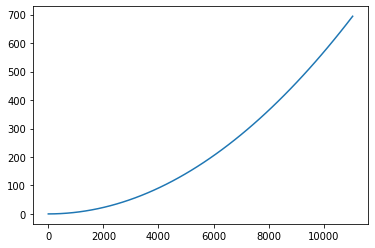

In [102]:
plt.plot(x0, z0)
plt.show()

In [103]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [104]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [105]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3],flag=1).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [107]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [108]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [109]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [110]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [111]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [112]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [113]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

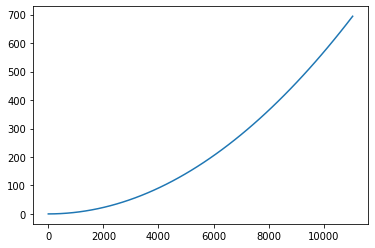

In [114]:
plt.plot(x0_, z0_)
plt.show()

In [115]:
init=1e-12
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.055*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([-0.0002*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [116]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [117]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [118]:
vehicle=semisub('DPcontrol',0,-5,40.0,0,0) 

In [119]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [120]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

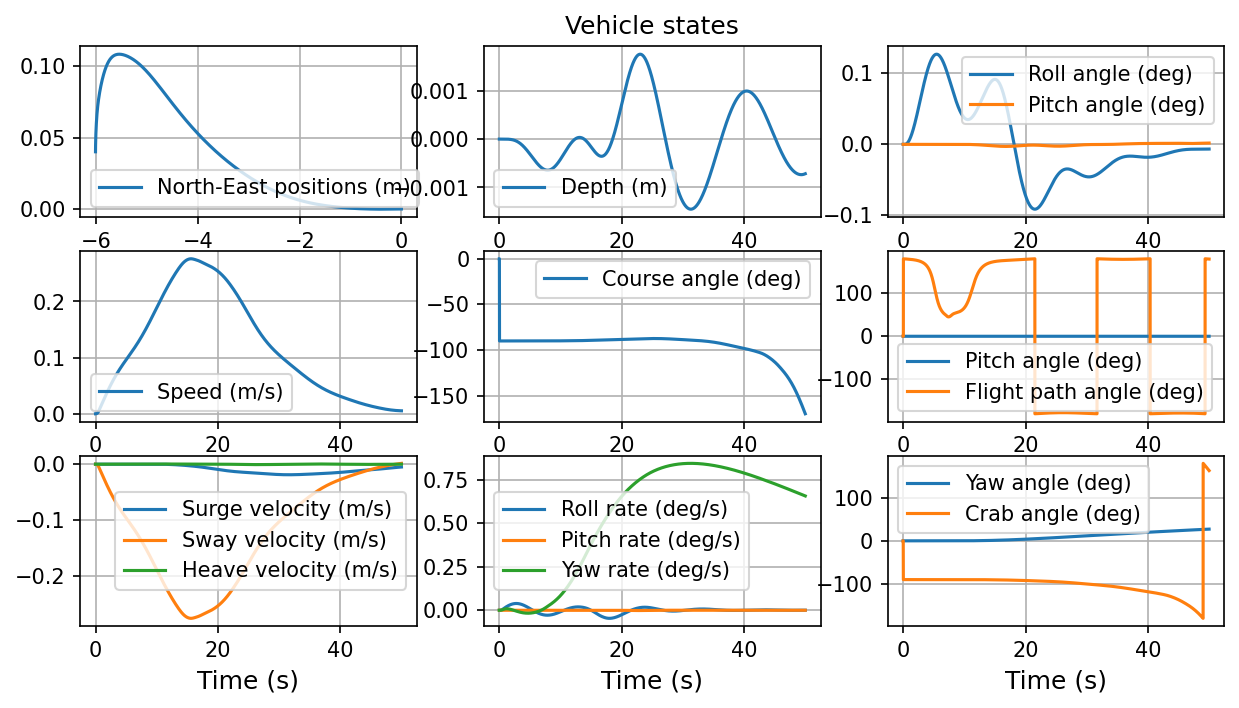

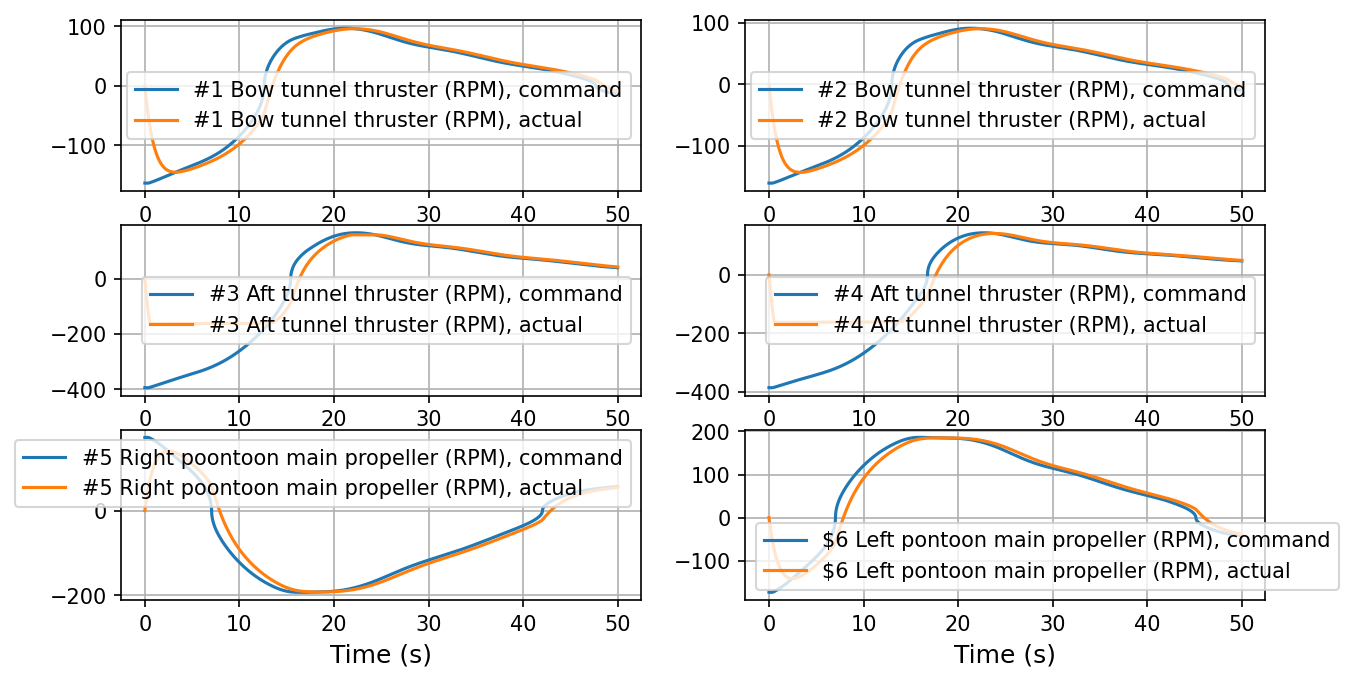

In [121]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [122]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

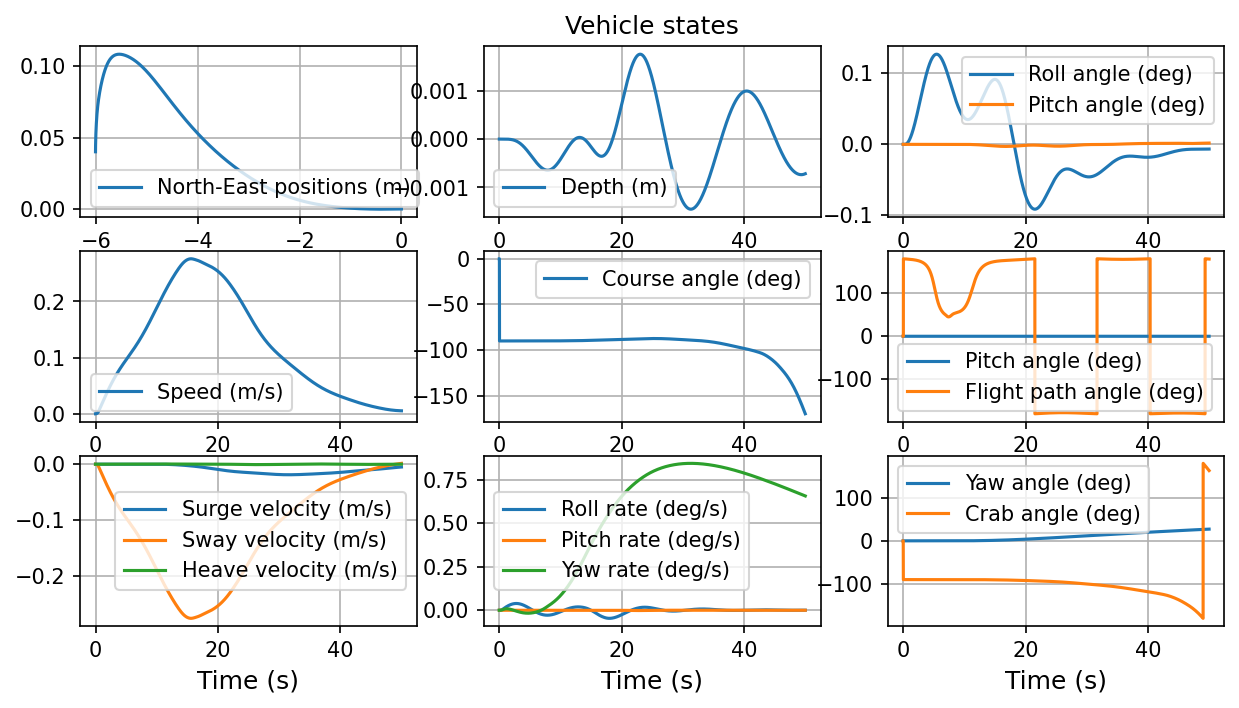

In [123]:
plotVehicleStates(simTime, simData, 3)

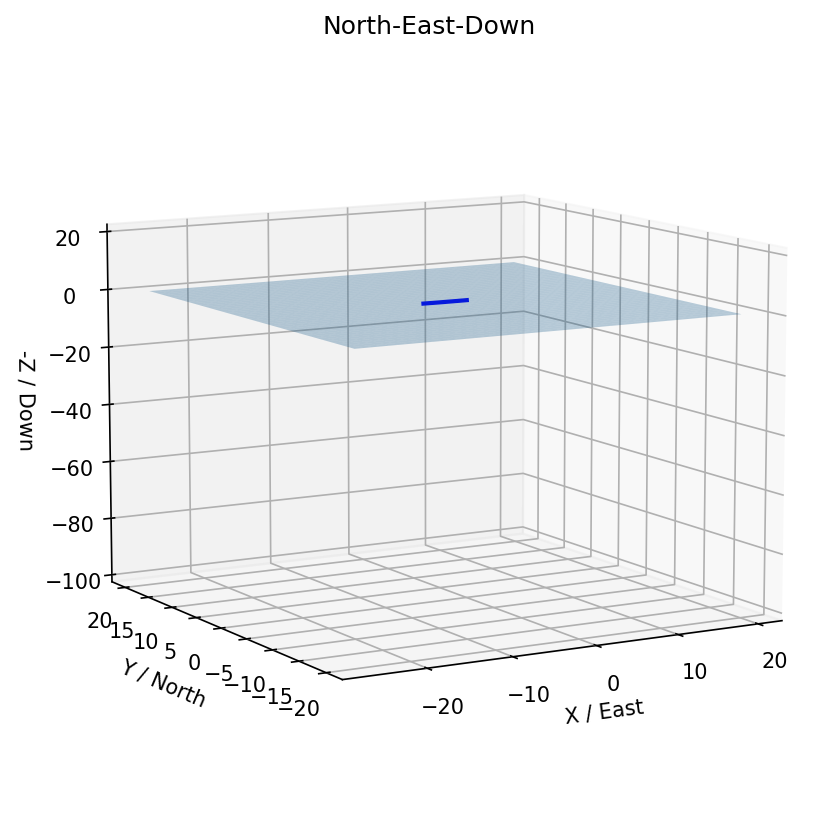

In [124]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [125]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [126]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [127]:
# Ws[0]*Ret[2]

In [128]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

### Dynamics

In [129]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

    
#     Z0=np.dot(Re_b(Ret.astype(np.float64)),tau_force[:3].astype(np.float64)).astype(np.float64)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3], flag=1).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 #+Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1e22
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [130]:
# import scipy

In [131]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [132]:
# us=ode15s.integrate(10)

In [133]:
tspan = (0., 50)

In [134]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:06.783673


In [135]:
# key takeaway: you can calibrate the model by tuning the hack and bc(init) 

### Results

In [136]:
fin=us

In [137]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 296
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.02848475e-02, 1.13133322e-01, 1.14161807e+00,
       1.87869898e+00, 2.61577989e+00, 3.68336552e+00, 4.98176300e+00,
       6.78961892e+00, 9.15215054e+00, 1.07028555e+01, 1.22535606e+01,
       1.42981964e+01, 1.62211527e+01, 1.81441090e+01, 1.97823522e+01,
       2.14205955e+01, 2.32780458e+01, 2.53145311e+01, 2.69280785e+01,
       2.85416259e+01, 3.04719978e+01, 3.25132634e+01, 3.45545290e+01,
       3.60255654e+01, 3.74966019e+01, 3.87577255e+01, 4.00188491e+01,
       4.12941018e+01, 4.22897488e+01, 4.32853958e+01, 4.44242786e+01,
       4.53039330e+01, 4.61835873e+01, 4.72322529e+01, 4.80236407e+01,
       4.88150285e+01, 4.98263590e+01, 5.00000000e+01])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.0000000

In [138]:
t=fin.t

In [139]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


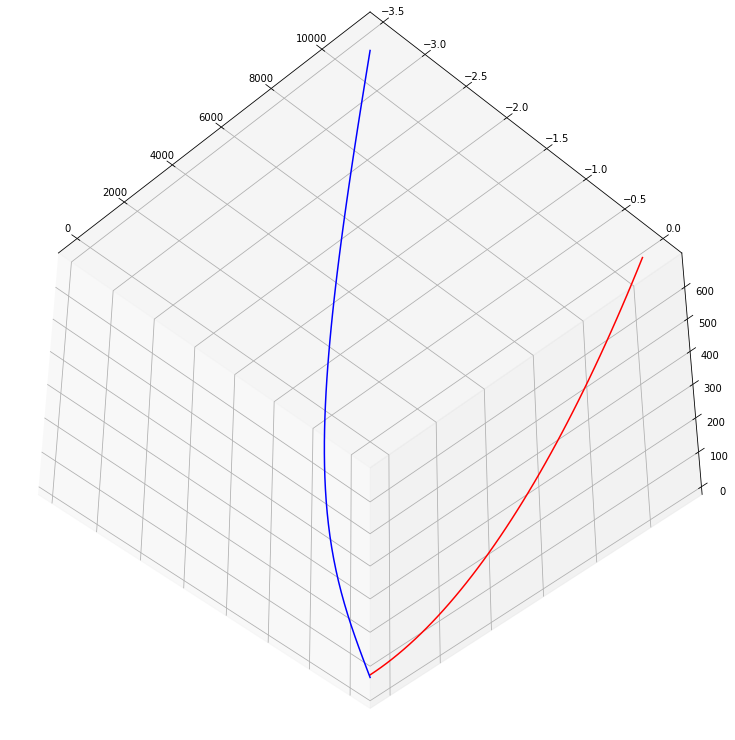

In [140]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [141]:
X,Y,Z

(array([    0.        ,   225.5649484 ,   451.12989602,   676.69485037,
          902.2598234 ,  1127.82483087,  1353.38989168,  1578.95502694,
         1804.52025913,  2030.08561112,  2255.65110535,  2481.216763  ,
         2706.78260342,  2932.34864366,  3157.91489809,  3383.48137829,
         3609.04809291,  3834.61504755,  4060.18224547,  4285.74968835,
         4511.31737439,  4736.88529893,  4962.45345685,  5188.02184184,
         5413.59044674,  5639.15926377,  5864.72828481,  6090.29750158,
         6315.86690583,  6541.43648867,  6767.00623838,  6992.57614606,
         7218.14620354,  7443.71640309,  7669.28673742,  7894.85719904,
         8120.42777888,  8345.99847027,  8571.56926808,  8797.14017158,
         9022.71117707,  9248.28227773,  9473.85346013,  9699.42471902,
         9924.99605017, 10150.56744967, 10376.13891389, 10601.7104395 ,
        10827.28202342, 11052.8536628 ]),
 array([ 0.        , -0.1157188 , -0.23213569, -0.34849999, -0.46405527,
        -0.57809187, 

In [142]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [143]:
us=fin.T

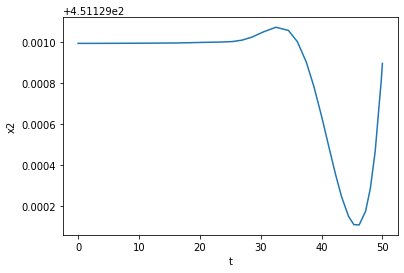

In [144]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

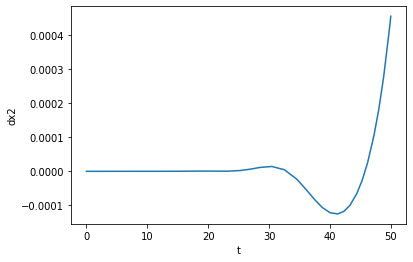

In [145]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

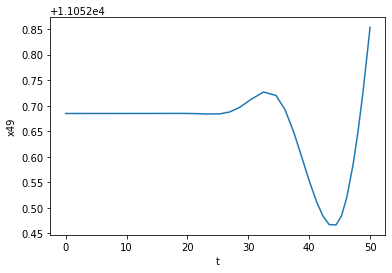

In [146]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

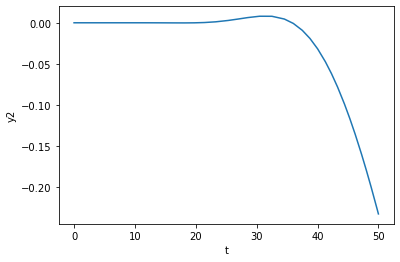

In [147]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

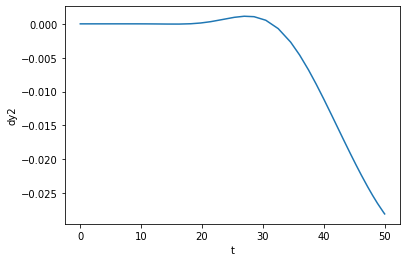

In [148]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

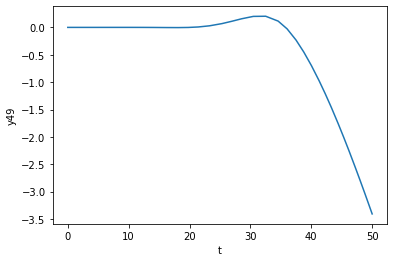

In [149]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

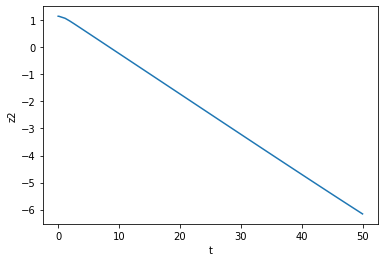

In [150]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

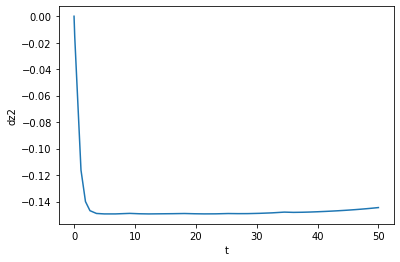

In [151]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

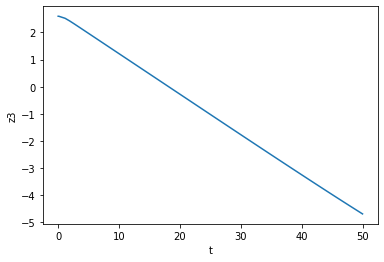

In [152]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

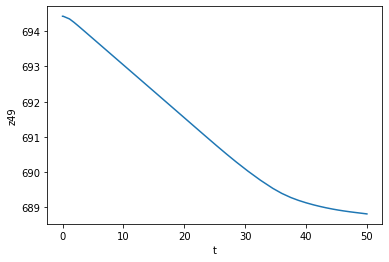

In [153]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

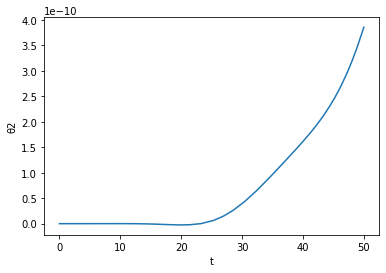

In [154]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

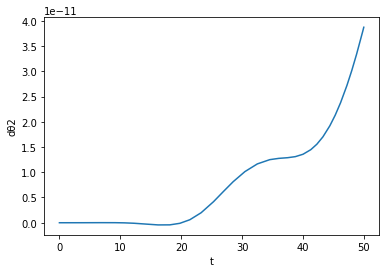

In [155]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

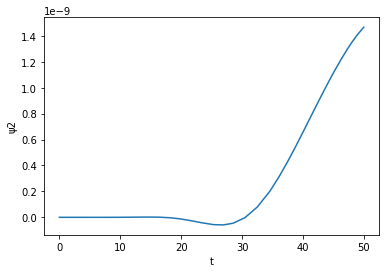

In [156]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

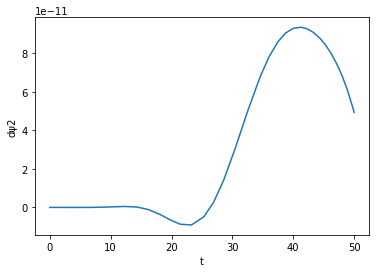

In [157]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()